# Intervention Model Classifier

Predict the intervention model from the pubmed abstract of a clinical trial

In [1]:
%store -r abstracts_targets

df = abstracts_targets.ix[:, ['abstract', 'pmid', 'intervention_model']]
df = df[df.intervention_model.notnull()] # filter away abstracts which don't have an associated intervention model

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2085 entries, 0 to 2126
Data columns (total 3 columns):
abstract              2085 non-null object
pmid                  2085 non-null object
intervention_model    2085 non-null object
dtypes: object(3)
memory usage: 65.2+ KB


In [2]:
df.groupby('intervention_model').size()

intervention_model
Crossover Assignment        157
Factorial Assignment         47
Parallel Assignment        1380
Single Group Assignment     501
dtype: int64

### View an Example from Each Class

In [3]:
labels = df.intervention_model.unique()

indexes = [df[df.intervention_model == label].iloc[0].name for label in labels]

for index in indexes:
    pm_url = 'https://www.google.com/search?q=pmid+' + df.iloc[index].pmid + '&btnI=I' # I'm Feeling Lucky
    
    print '*'*5, df.iloc[index].intervention_model, '*'*5
    print df.iloc[index].abstract
    print
    !google-chrome "{pm_url}"
    print

***** Parallel Assignment *****
D-Cycloserine, a partial agonist at the glycine site of the N-methyl-D-aspartate receptor, has demonstrated inconsistent efficacy for negative and cognitive symptoms of schizophrenia. The strongest evidence for efficacy has come from studies using D-cycloserine at a dose of 50 mg/day added to conventional antipsychotics in trials of 8 weeks duration or less. 
                 To assess the efficacy for negative symptoms and cognitive impairment of D-cycloserine augmentation of conventional antipsychotics in a 6-month trial. 
                 Fifty-five schizophrenia patients with prominent negative symptoms, treated with conventional antipsychotics, were randomly assigned to treatment with D-cycloserine 50 mg/day or placebo for 6 months in a double-blind, parallel group design. 
                 Twenty-six subjects completed the 6-month trial; drop-out rates did not differ between treatment groups. D-Cycloserine treatment did not differ from placebo trea

### Word Clouds for Each Class

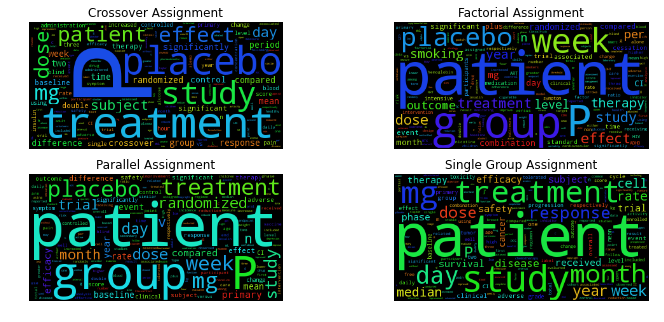

In [4]:
from support import word_cloud

fig = plt.figure(figsize=(12, 5))
plt.clf()

for i, label in enumerate(np.sort(df.intervention_model.unique()), start=1):
    axes = fig.add_subplot(2, 2, i)
    words = ' '.join(df[df.intervention_model == label].abstract)
    
    word_cloud(words, axes, label)
    
plt.axis('off')
plt.show()

### Train Test Split

In [5]:
from sklearn.cross_validation import train_test_split

abstracts_train, abstracts_test, ys_train, ys_test = train_test_split(df.abstract, df.intervention_model)

abstracts_train.shape, abstracts_test.shape, ys_train.shape, ys_test.shape

((1563,), (522,), (1563,), (522,))

### Vectorize Train and Test Abstracts

- Don't use `idf`. This allows for use of `HashingVectorizer` and performs just as well as using `idf`
- Use `binary=True` features. This works better than using `tf` features

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english', use_idf=False, binary=True) # simulate HashingVectorizer
vectorizer.fit(abstracts_train)

X_train, X_test = vectorizer.transform(abstracts_train), vectorizer.transform(abstracts_test)

X_train.shape

(1563, 170140)

### Extract and Order Vocabulary

In [7]:
import operator

vocabulary = [word for word, index in sorted(vectorizer.vocabulary_.items(), key=operator.itemgetter(1))]

### Hyperparameters

### Grid Search

#### Assumptions

- Running SGD for 1M runs is sufficient and `n_iter` is set accordingly
- Using binary features work better than counts
- The best alpha is somewhere between `np.logspace(-1.5,-3.5)`

#### Conclusion

`TF-IDF` gives negligable performance increases and `HashingVectorizer` is sufficient.

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] alpha=0.0316227766017 ...........................................
[CV] .................. alpha=0.0316227766017, score=0.387252 -   3.8s
[CV] alpha=0.0316227766017 ...........................................
[CV] .................. alpha=0.0316227766017, score=0.415642 -   3.8s
[CV] alpha=0.0316227766017 ...........................................
[CV] .................. alpha=0.0316227766017, score=0.418786 -   3.6s
[CV] alpha=0.0316227766017 ...........................................
[CV] .................. alpha=0.0316227766017, score=0.417738 -   3.6s
[CV] alpha=0.0316227766017 ...........................................
[CV] .................. alpha=0.0316227766017, score=0.428757 -   3.6s
[CV] alpha=0.0189573565241 ...........................................
[CV] .................. alpha=0.0189573565241, score=0.520865 -   3.5s
[CV] alpha=0.0189573565241 ...........................................
[CV] ...........

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    3.8s
[Parallel(n_jobs=1)]: Done  32 jobs       | elapsed:  1.8min



[CV] alpha=0.00146779926762 ..........................................
[CV] ................. alpha=0.00146779926762, score=0.652806 -   3.3s
[CV] alpha=0.00146779926762 ..........................................
[CV] ................. alpha=0.00146779926762, score=0.585427 -   3.3s
[CV] alpha=0.00146779926762 ..........................................
[CV] ................. alpha=0.00146779926762, score=0.585853 -   3.3s
[CV] alpha=0.000879922543569 .........................................
[CV] ................ alpha=0.000879922543569, score=0.524478 -   3.3s
[CV] alpha=0.000879922543569 .........................................
[CV] ................ alpha=0.000879922543569, score=0.589908 -   3.3s
[CV] alpha=0.000879922543569 .........................................
[CV] ................ alpha=0.000879922543569, score=0.604004 -   3.3s
[CV] alpha=0.000879922543569 .........................................
[CV] ................ alpha=0.000879922543569, score=0.581776 -   3.3s
[CV] 

/home/ebanner/.anaconda/envs/py27/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.8min finished


/home/ebanner/.anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


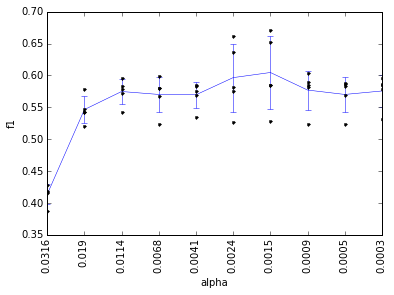

In [8]:
from sklearn.linear_model import SGDClassifier
from sklearn.grid_search import GridSearchCV

M, N = X_train.shape
K = 5 # number of folds for cross-validation

clf = SGDClassifier(class_weight='auto', n_iter=int(np.ceil(10**6/(M-M/K)))) # http://scikit-learn.org/stable/modules/sgd.html#tips-on-practical-use

parameters = {
    'alpha': np.logspace(-1.5, -3.5, 10)
}

grid_search = GridSearchCV(clf, parameters, verbose=3, scoring='f1_macro', cv=K)
grid_search.fit(X_train, ys_train)

# Get scores for different hyperparam settings into dataframe
df = pd.DataFrame(grid_search.grid_scores_, columns=grid_search.grid_scores_[0]._fields)

# Explode cv scores for each hyperparam setting
scores = df.cv_validation_scores.apply(pd.Series)
scores = scores.rename(columns=lambda x: 's{}'.format(x))
score_columns = scores.columns

scores['f1'], scores['err'] = scores.mean(axis=1), scores.std(axis=1) # mean f1 and stddev for cv scores

alphas = df.parameters.apply(lambda x: pd.Series(x))

df = pd.concat([alphas, scores], axis=1).fillna(0) # concatenate the two back together

# Plot f1 and all the scores for each hyperparam setting
axes = df['f1'].plot(yerr=df.err, linewidth=.5)
for s in score_columns:
    axes = df[s].plot(ax=axes, style='.', c='black')

# Fix axes
tick_marks = np.arange(len(alphas))
plt.xticks(tick_marks, df.alpha.round(4), rotation=90)
axes.set_xlabel('alpha')
axes.set_ylabel('f1')

### Best `(clf, tf-idf)` Pair

In [9]:
best_clf = grid_search.best_estimator_

grid_search.best_score_, best_clf

(0.60460415575240611,
 SGDClassifier(alpha=0.0014677992676220704, average=False, class_weight='auto',
        epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
        learning_rate='optimal', loss='hinge', n_iter=799, n_jobs=1,
        penalty='l2', power_t=0.5, random_state=None, shuffle=True,
        verbose=0, warm_start=False))

### Prediction on Test Set

In [10]:
X_test = vectorizer.transform(abstracts_test)
predictions = best_clf.predict(X_test)

# Compute f1s for all classes
import sklearn
lb = sklearn.preprocessing.LabelBinarizer()
f1s = sklearn.metrics.f1_score(lb.fit_transform(ys_test), lb.fit_transform(predictions), average=None)

# Display f1s
import re
from collections import namedtuple
Classes = namedtuple('Classes', [re.sub('\s+', '_', class_) for class_ in best_clf.classes_])

print 'f1s: {}'.format({label: f1 for label, f1 in zip(best_clf.classes_, f1s)})
print
print 'Average: {}'.format(np.mean(f1s))

f1s: {'Factorial Assignment': 0.14999999999999999, 'Parallel Assignment': 0.83870967741935487, 'Crossover Assignment': 0.52173913043478248, 'Single Group Assignment': 0.77394636015325668}

Average: 0.571098792002


### Confusion Matrix

#### Observations

- Crossover assignment is often confused as parallel assignment. This makes sense as there are multiple groups, just as in parallel assignment
- Factorial assignment f1 is very low because we just don't have enough data for them. In the word clouds below, you can see *adhd* as being the most strongly correlated unigram with factorial assignments, instead of *combination*, which makes more sense
- Parallel assignment is often classified correctly. The model confuses parallel and single groups

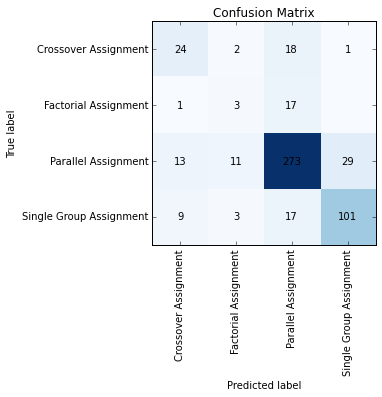

In [11]:
confusion_matrix = sklearn.metrics.confusion_matrix(ys_test, predictions)

fig = plt.figure()
plt.clf()

labels = best_clf.classes_

plt.imshow(confusion_matrix, cmap=plt.cm.Blues, interpolation='nearest')
plt.title('Confusion Matrix')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=90)
plt.yticks(tick_marks, labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')

width = height = len(labels)

for x in xrange(width):
    for y in xrange(height):
        plt.annotate(str(confusion_matrix[x][y]) if confusion_matrix[x][y] else '', xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')

### Features with Highest Coefficients

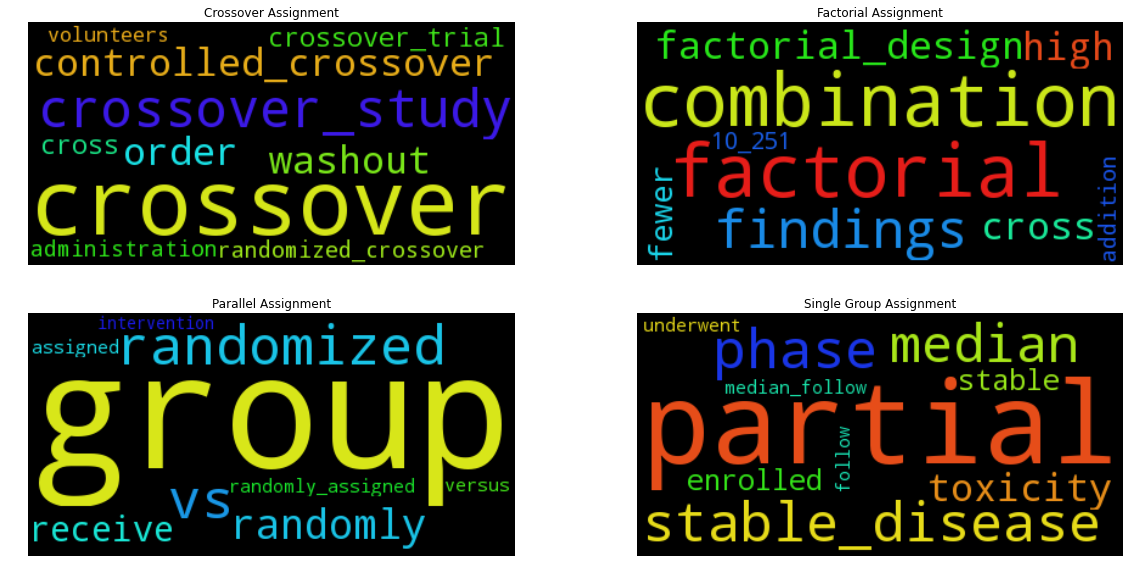

In [12]:
import re

fig = plt.figure(figsize=(20, 20))
plt.clf()

for i, (weights, title) in enumerate(zip(best_clf.coef_, labels), start=1):
    pairs = sorted(zip(weights, vocabulary), reverse=True)[:10]
    pairs = [(pair[0], re.sub('\s+', '_', pair[1])) for pair in pairs]
    
    def duplicate_words(pairs):
        """Yields words duplicated proportional to their corresponding coefficients"""
        
        for coef, word in pairs:
            for _ in range(int(coef*100)):
                yield word
            
    duped_words = list(duplicate_words(pairs))
    
    axes = fig.add_subplot(4, 2, i)
    word_cloud(' '.join(duped_words), axes, title)
    
plt.axis('off')
plt.show()